In [4]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

#Importando os dados
file_path = "dataset.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "maharshipandya/-spotify-tracks-dataset",
    file_path,
)

# Carregar dataset
df = df.dropna()

# Remover coluna de índice duplicado
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

#Reduzindo a sample para acelerar os testes
df = df.sample(10000, random_state=42)

# Features numéricas relevantes
features = [
    "popularity", "danceability", "energy", "loudness",
    "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "duration_ms"
]

X = df[features]

# Target = gênero musical da track
y = LabelEncoder().fit_transform(df["track_genre"])

# Normalização
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Número de classes (gêneros):", len(np.unique(y)))


/tmp/ipython-input-146924552.py:14: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


X_train shape: (8000, 11)
X_test shape: (2000, 11)
Número de classes (gêneros): 114


In [ ]:
# Testar valores de K
inertias = []
silhouettes = []
K_range = range(2, 100, 5)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_train, kmeans.labels_))

# Plot método do cotovelo
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inércia (WCSS)")
plt.title("Método do Cotovelo")
plt.show()

# Plot índice de silhueta
plt.plot(K_range, silhouettes, marker='o')
plt.xlabel("Número de clusters (K)")
plt.ylabel("Índice de Silhueta")
plt.title("Qualidade de clusterização")
plt.show()

In [5]:
# Definir K ótimo
best_k = 15
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_train)

def cluster_distance_features(X, model):
    distances = model.transform(X)  # distâncias a todos os clusters
    min_dist = np.min(distances, axis=1).reshape(-1, 1)
    return np.hstack([X, min_dist])

X_train_expanded = cluster_distance_features(X_train, kmeans)
X_test_expanded = cluster_distance_features(X_test, kmeans)




Executando GridSearchCV para SVM Linear...
Melhores parâmetros para SVM Linear: {'C': 1, 'kernel': 'linear'}

Treinando SVM Linear (GridSearch)...
SVM Linear (GridSearch) concluído em 45.66 segundos

Executando GridSearchCV para SVM Linear (Expanded)...
Melhores parâmetros para SVM Linear (Expanded): {'C': 1, 'kernel': 'linear'}

Treinando SVM Linear (Expanded) (GridSearch)...
SVM Linear (Expanded) (GridSearch) concluído em 43.44 segundos

Executando GridSearchCV para SVM RBF/Poly...
Melhores parâmetros para SVM RBF/Poly: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Treinando SVM RBF/Poly (GridSearch)...
SVM RBF/Poly (GridSearch) concluído em 48.87 segundos

Executando GridSearchCV para SVM RBF/Poly (Expanded)...
Melhores parâmetros para SVM RBF/Poly (Expanded): {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Treinando SVM RBF/Poly (Expanded) (GridSearch)...
SVM RBF/Poly (Expanded) (GridSearch) concluído em 48.16 segundos

Melhores parâmetros SVM:
Linear: {'C': 1, 'kernel': 'linear'}
R

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Melhores parâmetros para RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Treinando RandomForest (GridSearch)...
RandomForest (GridSearch) concluído em 22.93 segundos

Executando GridSearchCV para RandomForest (Expanded)...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Melhores parâmetros para RandomForest (Expanded): {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Treinando RandomForest (Expanded) (GridSearch)...
RandomForest (Expanded) (GridSearch) concluído em 21.81 segundos

Melhores parâmetros encontrados:
RandomForest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

===== RESUMO DE MÉTRICAS POR MODELO =====
                           Model  Accuracy  Precision_macro  Recall_macro  F1_macro  Precision_weighted  Recall_weighted  F1_weighted  AUC_macro_OvR  AUC_weighted_OvR  AUC_macro_OvO  AUC_weighted_OvO  AUC_binary
                   RF_GridSearch    0.2945         0.273902      0.291235  0.273204            0.276394           0.2945     0.276077       0.871747          0.872397       0.871646          0.872015         NaN
          RF_GridSearch_Expanded    0.2895         0.266539      0.286414  0.267459            

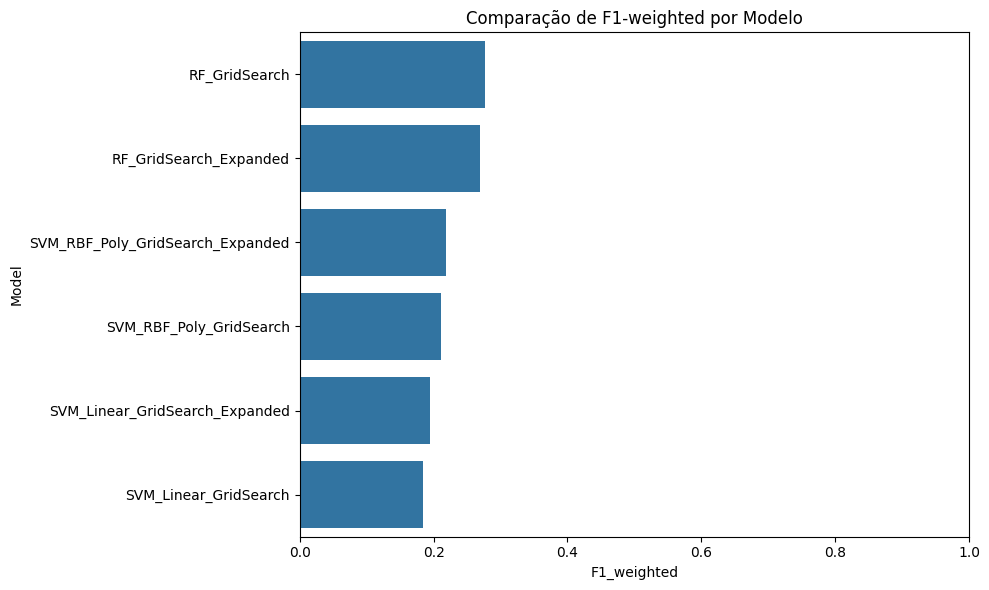

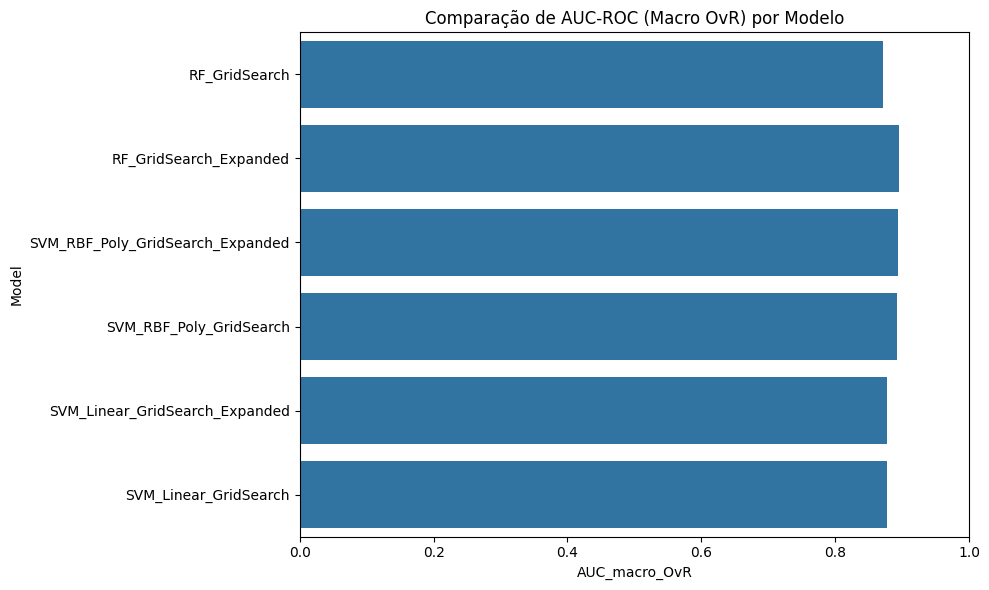

In [9]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

results = {}
roc_data = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    print(f"\nTreinando {name}...")
    start_time = time.time()

    # Para LinearSVC, calibrar para ter probabilidades
    if isinstance(model, LinearSVC):
        model = CalibratedClassifierCV(model)

    model.fit(X_train, y_train)

    # Previsão e relatório completo (por classe + macro/weighted)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Probabilidades/scores para AUC
    auc_scores = None
    try:
        y_score = model.predict_proba(X_test)
        roc_data[name] = {"y_test": y_test, "y_score": y_score}

        # Multiclasse: médias macro/weighted em OvR e OvO
        auc_scores = {
            "macro_ovr": roc_auc_score(y_test, y_score, multi_class="ovr", average="macro"),
            "weighted_ovr": roc_auc_score(y_test, y_score, multi_class="ovr", average="weighted"),
            "macro_ovo": roc_auc_score(y_test, y_score, multi_class="ovo", average="macro"),
            "weighted_ovo": roc_auc_score(y_test, y_score, multi_class="ovo", average="weighted"),
        }

    except Exception:
        auc_scores = None

    end_time = time.time()
    print(f"{name} concluído em {end_time - start_time:.2f} segundos")

    # liberar memória de objetos grandes
    del y_pred
    gc.collect()

    return {"report": report, "auc": auc_scores}

# ------------------ Função utilitária para GridSearch + avaliação ------------------
def grid_search_evaluate(name, model, param_grid, X_train, X_test, y_train, y_test, cv=3):
    print(f"\nExecutando GridSearchCV para {name}...")
    grid = GridSearchCV(model, param_grid, scoring="f1_weighted", cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print(f"Melhores parâmetros para {name}: {grid.best_params_}")

    metrics = evaluate_model(name + " (GridSearch)", best_model, X_train, X_test, y_train, y_test)
    return metrics, grid.best_params_

# ------------------ SVM com GridSearch ------------------
# Kernel linear:
param_grid_linear = {"C": [1, 10], "kernel": ["linear"]}

# Kernels rbf/poly:
param_grid_non_linear = {
    "C": [1, 10],
    "kernel": ["rbf", "poly"],
    "gamma": ["scale"]
}

# GridSearch kernel linear
results_svm_linear, best_params_linear = grid_search_evaluate(
    "SVM Linear", SVC(probability=True), param_grid_linear, X_train, X_test, y_train, y_test
)

# GridSearch kernel linear com features expandidas
results_svm_linear_exp, _ = grid_search_evaluate(
    "SVM Linear (Expanded)", SVC(probability=True), param_grid_linear, X_train_expanded, X_test_expanded, y_train, y_test
)

# GridSearch kernels rbf/poly
results_svm_non_linear, best_params_non_linear = grid_search_evaluate(
    "SVM RBF/Poly", SVC(probability=True), param_grid_non_linear, X_train, X_test, y_train, y_test
)

#GridSearch kernels rbf/poly com features expandidas
results_svm_non_linear_exp, _ = grid_search_evaluate(
    "SVM RBF/Poly (Expanded)", SVC(probability=True), param_grid_non_linear, X_train_expanded, X_test_expanded, y_train, y_test
)

# Armazenar resultados
results.update({
    "SVM_Linear_GridSearch": results_svm_linear,
    "SVM_RBF_Poly_GridSearch": results_svm_non_linear,
    "SVM_Linear_GridSearch_Expanded": results_svm_linear_exp,
    "SVM_RBF_Poly_GridSearch_Expanded": results_svm_non_linear_exp
})

# Mostrar melhores parâmetros encontrados
print("\nMelhores parâmetros SVM:")
print("Linear:", best_params_linear)
print("RBF/Poly:", best_params_non_linear)

# ------------------ RandomForest com GridSearch ------------------
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1],
    "max_features": ["sqrt", None]
}

results_rf_grid, best_rf_params = grid_search_evaluate(
    "RandomForest", RandomForestClassifier(random_state=42, n_jobs=-1), rf_param_grid,
    X_train, X_test, y_train, y_test
)

# Testando com features expandidas
results_rf_grid_expanded, _ = grid_search_evaluate(
    "RandomForest (Expanded)", RandomForestClassifier(random_state=42, n_jobs=-1), rf_param_grid,
    X_train_expanded, X_test_expanded, y_train, y_test
)

# Armazenando resultados
results.update({
    "RF_GridSearch": results_rf_grid,
    "RF_GridSearch_Expanded": results_rf_grid_expanded
})

print("\nMelhores parâmetros encontrados:")
print("RandomForest:", best_rf_params)


# ------------------ RELATÓRIO RESUMO: precisão/recall/F1/AUC por modelo ------------------
summary_rows = []
for model_name, metrics in results.items():
    rep = metrics["report"]
    aucs = metrics["auc"] or {}

    # métricas agregadas do classification_report
    acc = rep.get("accuracy", np.nan)
    macro = rep.get("macro avg", {})
    weighted = rep.get("weighted avg", {})

    row = {
        "Model": model_name,
        "Accuracy": acc,
        "Precision_macro": macro.get("precision", np.nan),
        "Recall_macro": macro.get("recall", np.nan),
        "F1_macro": macro.get("f1-score", np.nan),
        "Precision_weighted": weighted.get("precision", np.nan),
        "Recall_weighted": weighted.get("recall", np.nan),
        "F1_weighted": weighted.get("f1-score", np.nan),
        "AUC_macro_OvR": aucs.get("macro_ovr", np.nan),
        "AUC_weighted_OvR": aucs.get("weighted_ovr", np.nan),
        "AUC_macro_OvO": aucs.get("macro_ovo", np.nan),
        "AUC_weighted_OvO": aucs.get("weighted_ovo", np.nan),
        "AUC_binary": aucs.get("binary", np.nan),
    }
    summary_rows.append(row)

df_metrics = pd.DataFrame(summary_rows).sort_values(by=["F1_weighted"], ascending=False)
print("\n===== RESUMO DE MÉTRICAS POR MODELO =====")
print(df_metrics.to_string(index=False))

# F1-weighted
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x="F1_weighted", y="Model")
plt.title("Comparação de F1-weighted por Modelo")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

# AUC média (macro OvR)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x="AUC_macro_OvR", y="Model")
plt.title("Comparação de AUC-ROC (Macro OvR) por Modelo")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()